In [1]:
import random
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pickle

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

In [3]:
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)

In [4]:
traveltime_cutoff = 45

### Figure 17: Detection of Cluster Centroids

In [5]:
# read in minimum travel time data
with open('../90 Data/compiled secondary data/old_ttm_baseline_ampeak', 'rb') as infile:
    old_ttm_baseline_ampeak = pickle.load(infile)

# convert travel time matrix from long-form to wide-form
old_ttm_baseline_ampeak_wide = pd.pivot_table(old_ttm_baseline_ampeak, values = 'min_traveltime', index = 'orig_id', 
                                             columns = 'dest_id', fill_value = np.max(old_ttm_baseline_ampeak['min_traveltime'])*2) # to fill in missing traveltime values

In [6]:
# randomly permutate the order of MSOAs by the same order in rows and columns
index_randperm = old_ttm_baseline_ampeak_wide.sample(frac = 1).index
ttm_baseline_ampeak_randperm = old_ttm_baseline_ampeak_wide.loc[index_randperm,index_randperm]

# calculate cosine similarity between row vectors of travel times
cosine_sim_ttm_baseline_ampeak_randperm = cosine_similarity(ttm_baseline_ampeak_randperm)

C:\Users\Daniel Leong\Anaconda3\lib\site-packages\sklearn\cluster\bicluster.py:296: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for c in range(self.n_clusters))
C:\Users\Daniel Leong\Anaconda3\lib\site-packages\sklearn\cluster\bicluster.py:298: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for c in range(self.n_clusters))


Spectral Coclustering Results for n_cluster in [2,3,4,5,6,7,8,9,10,15,20,25,30]


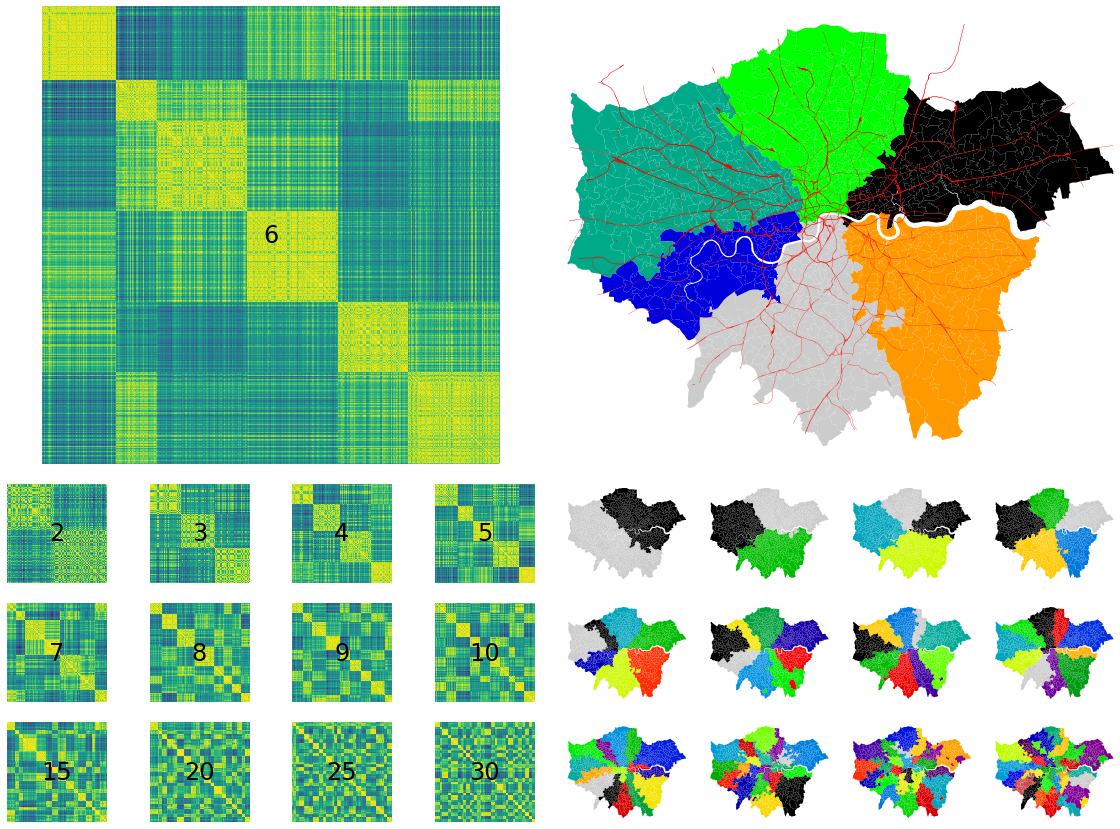

In [7]:
# calculate spectral coclustering for variety of number of clusters
n_clusters = [2,3,4,5,6,7,8,9,10,15,20,25,30]
clustering = {'fitdata': [], 'clustered_msoas': []}
plottingsettings = {'grid_rows': 7,
                    'grid_cols': 8,
                    'grid_pos': [[[4,5],[0,1]], # position of each plot generated from n_clusters in the GridSpec
                                 [[4,5],[1,2]],
                                 [[4,5],[2,3]],
                                 [[4,5],[3,4]],
                                 [[0,4],[0,4]],
                                 [[5,6],[0,1]],
                                 [[5,6],[1,2]],
                                 [[5,6],[2,3]],
                                 [[5,6],[3,4]],
                                 [[6,7],[0,1]],
                                 [[6,7],[1,2]],
                                 [[6,7],[2,3]],
                                 [[6,7],[3,4]]
                                ]
                   }

for n in n_clusters:
    # fitting spectral coclustering model
    model = SpectralCoclustering(n_clusters = n, n_svd_vecs=1)
    model.fit(cosine_sim_ttm_baseline_ampeak_randperm)

    fit_data = cosine_sim_ttm_baseline_ampeak_randperm[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]
    clustering['fitdata'].append(fit_data)
    
    # assigning clustering to spatial data
    clusters = np.dstack((index_randperm, model.row_labels_))[0]
    clusters = clusters[np.argsort(index_randperm)]

    clustered_msoa = pd.DataFrame({'cluster' : clusters[:,1]}, index = old_ttm_baseline_ampeak_wide.index)
    clustered_msoa = msoas.join(clustered_msoa)
    clustering['clustered_msoas'].append(clustered_msoa)

# setting up plot
fig3 = plt.figure(figsize = (20,15))
gs3 = GridSpec(plottingsettings['grid_rows'],plottingsettings['grid_cols'], figure = fig3)
print('Spectral Coclustering Results for n_cluster in [2,3,4,5,6,7,8,9,10,15,20,25,30]')

for plot in range(len(n_clusters)):
    # plot matrix in corresponding grid location specified in grid_pos
    current_ax = fig3.add_subplot(gs3[plottingsettings['grid_pos'][plot][0][0]:plottingsettings['grid_pos'][plot][0][1],
                                    plottingsettings['grid_pos'][plot][1][0]:plottingsettings['grid_pos'][plot][1][1]])
    current_ax.imshow(clustering['fitdata'][plot])
    current_ax.text(0.5, 0.5, n_clusters[plot], fontsize = 24, va = 'center', ha = 'center', transform = current_ax.transAxes)
    plt.axis('off')
    
    # plot map in corresponding grid location 4 columns over
    current_map = fig3.add_subplot(gs3[plottingsettings['grid_pos'][plot][0][0]:plottingsettings['grid_pos'][plot][0][1],
                                    plottingsettings['grid_pos'][plot][1][0]+4:plottingsettings['grid_pos'][plot][1][1]+4])
    set_zoom(current_map, msoas)
    clustering['clustered_msoas'][plot].plot(column = 'cluster', linewidth = 0, cmap = 'nipy_spectral', categorical = True, ax = current_map)
    
    if plot == 4:
        # overlay rail and tube map only on main figure
        londontube.plot(ax = current_map, color = 'red', linewidth = 0.3)
        londonrail.plot(ax = current_map, color = 'red', linewidth = 0.3)
    
    plt.axis('off')

### Figure 18: Weighted Mean Travel Times to Destination MSOAs

In [8]:
with open('../90 Data/compiled secondary data/jobcounts', 'rb') as infile:
    jobcounts = pickle.load(infile)
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)

In [9]:
# use clustering for n = 6
clustered_msoas = clustering['clustered_msoas'][4][['cluster']]

# join clustering data to long-form ttm
cluster_centroid_detection_data = old_ttm_baseline_ampeak[['orig_id','dest_id','min_traveltime']].merge(clustered_msoas, left_on = 'orig_id', right_index = True)
cluster_centroid_detection_data = cluster_centroid_detection_data.merge(clustered_msoas, left_on = 'dest_id', right_index = True, suffixes = ('_orig', '_dest'))

# retain only pairs where origin and destination are in the same cluster
cluster_centroid_detection_data = cluster_centroid_detection_data[cluster_centroid_detection_data['cluster_orig'] == cluster_centroid_detection_data['cluster_dest']]
# join pop counts
cluster_centroid_detection_data = cluster_centroid_detection_data.merge(popcounts[['Pop_WorkingAge']], how = 'left', left_on = 'dest_id', right_index = True)
# calculate mean traveltime to from all origins in same cluster, weighted by number of pop in origins
cluster_centroid_detection_data['traveltime_x_pop'] = cluster_centroid_detection_data['min_traveltime'] * cluster_centroid_detection_data['Pop_WorkingAge']
msoa_popwtd_mean_traveltime_to_jobs = cluster_centroid_detection_data.groupby('dest_id').sum()
msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] = msoa_popwtd_mean_traveltime_to_jobs['traveltime_x_pop'] / msoa_popwtd_mean_traveltime_to_jobs['Pop_WorkingAge']
# rejoin destination-based clustering data
msoa_popwtd_mean_traveltime_to_jobs = msoa_popwtd_mean_traveltime_to_jobs.join(clustered_msoas)
# obtain minimum jobs-weighted mean traveltimes for each cluster
cluster_min_popwtd_mean_traveltime_to_jobs = msoa_popwtd_mean_traveltime_to_jobs.groupby('cluster').min()[['Pop Weighted Mean Traveltime']]
cluster_min_popwtd_mean_traveltime_to_jobs

,Pop Weighted Mean Traveltime
cluster,
0,36.582278
1,37.078652
2,43.419689
3,35.653061
4,40.966667
5,39.121827


In [10]:
# identify which MSOAs have the minimum mean pop-weighted travel times from origins in the same cluster
cluster_centroids = msoa_popwtd_mean_traveltime_to_jobs.loc[((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 0) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[0,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 1) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[1,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 2) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[2,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 3) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[3,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 4) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[4,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 5) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[5,'Pop Weighted Mean Traveltime']))].index


Potential Workers-Weighted Mean Travel Time
from all MSOAs in the same Cluster to each MSOA


(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

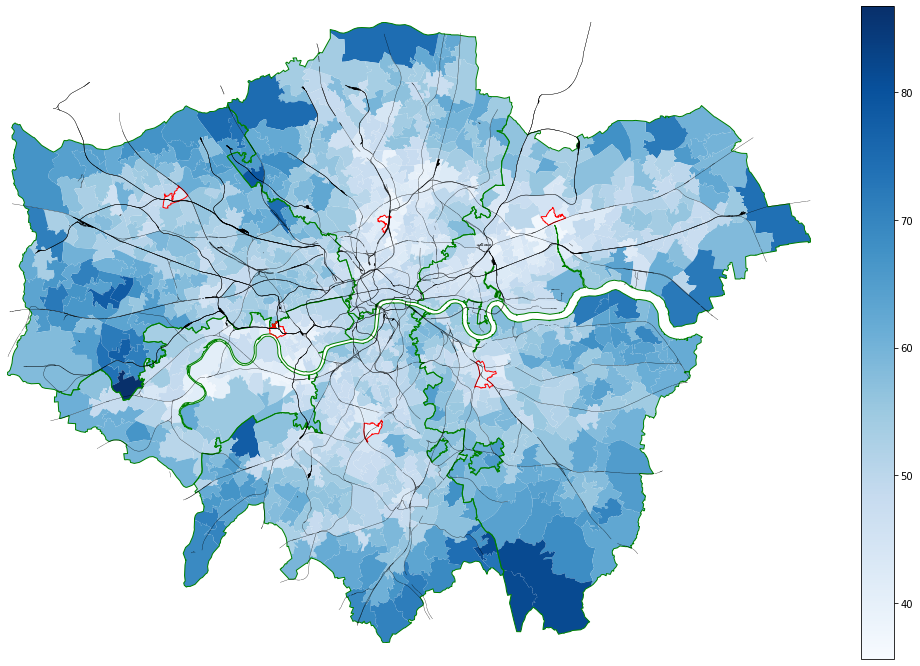

In [11]:
# plot map
fig01 = plt.figure(figsize = (18,12))
ax01_01 = fig01.add_subplot(111)
set_zoom(ax01_01, msoas)
# plot weighted mean traveltimes from cluster origins to each MSOA destination
msoas.join(msoa_popwtd_mean_traveltime_to_jobs).plot(column = 'Pop Weighted Mean Traveltime', cmap = 'Blues', legend = True, ax = ax01_01)
msoas.join(msoa_popwtd_mean_traveltime_to_jobs).dissolve(by = 'cluster').buffer(1).plot(ax = ax01_01, color = 'None', edgecolor = 'green')
msoas.loc[cluster_centroids, :].plot(ax = ax01_01, color = 'None', edgecolor = 'red')
londontube.plot(ax = ax01_01, color = 'black', linewidth = .3)
londonrail.plot(ax = ax01_01, color = 'black', linewidth = .3)
print('Potential Workers-Weighted Mean Travel Time\nfrom all MSOAs in the same Cluster to each MSOA')
plt.axis('off')

### Figure 12: Reliability Buffer Time of Trips to 7 Destinations

In [12]:
# add City to centroids list
cluster_centroids = list(cluster_centroids)
cluster_centroids.append('E02000001')
cluster_centroids

['E02000384',
 'E02000455',
 'E02000558',
 'E02000649',
 'E02000664',
 'E02000779',
 'E02000001']

In [13]:
centroid_names = {cluster_centroids[0]: 'Hammersmith',
                  cluster_centroids[1]: 'Harrow-on-the-Hill',
                  cluster_centroids[2]: 'Finsbury Park',
                  cluster_centroids[3]: 'Streatham',
                  cluster_centroids[4]: 'Lewisham',
                  cluster_centroids[5]: 'Ilford',
                  cluster_centroids[6]: 'City'}

In [14]:
# read in observed travel times for all trips ending in the 7 centroids
with open ('../90 Data/compiled secondary data/observed_traveltimes', 'rb') as infile:
    observed_traveltimes = pickle.load(infile)

In [15]:
for centroid in cluster_centroids:
    observed_traveltimes[centroid]['traveltime_variability'] = pd.DataFrame(columns = ['orig_id','dest_id','Median', '5PC', '95PC', 'Range 5PC to 95PC', 'Interquartile Range'])
    for pair in observed_traveltimes[centroid]['rawdata'].keys():
        observed_traveltimes[centroid]['traveltime_variability'] = observed_traveltimes[centroid]['traveltime_variability'].append({'orig_id': pair.split('-')[0],
                                                                                                                                    'dest_id': pair.split('-')[1], 
                                                                                                                                    'Median': np.median(observed_traveltimes[centroid]['rawdata'][pair]),
                                                                                                                                    '5PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .05),
                                                                                                                                    '95PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .95),
                                                                                                                                    'Range 5PC to 95PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .95) - np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .05),
                                                                                                                                    'Range 50PC to 95PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .95) - np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .5),
                                                                                                                                    'Interquartile Range': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .75) - np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .25)},
                                                                                                                                    ignore_index = True)
    observed_traveltimes[centroid]['traveltime_variability'].set_index('orig_id', inplace = True)
    observed_traveltimes[centroid]['traveltime_variability'] = msoas.join(observed_traveltimes[centroid]['traveltime_variability'])

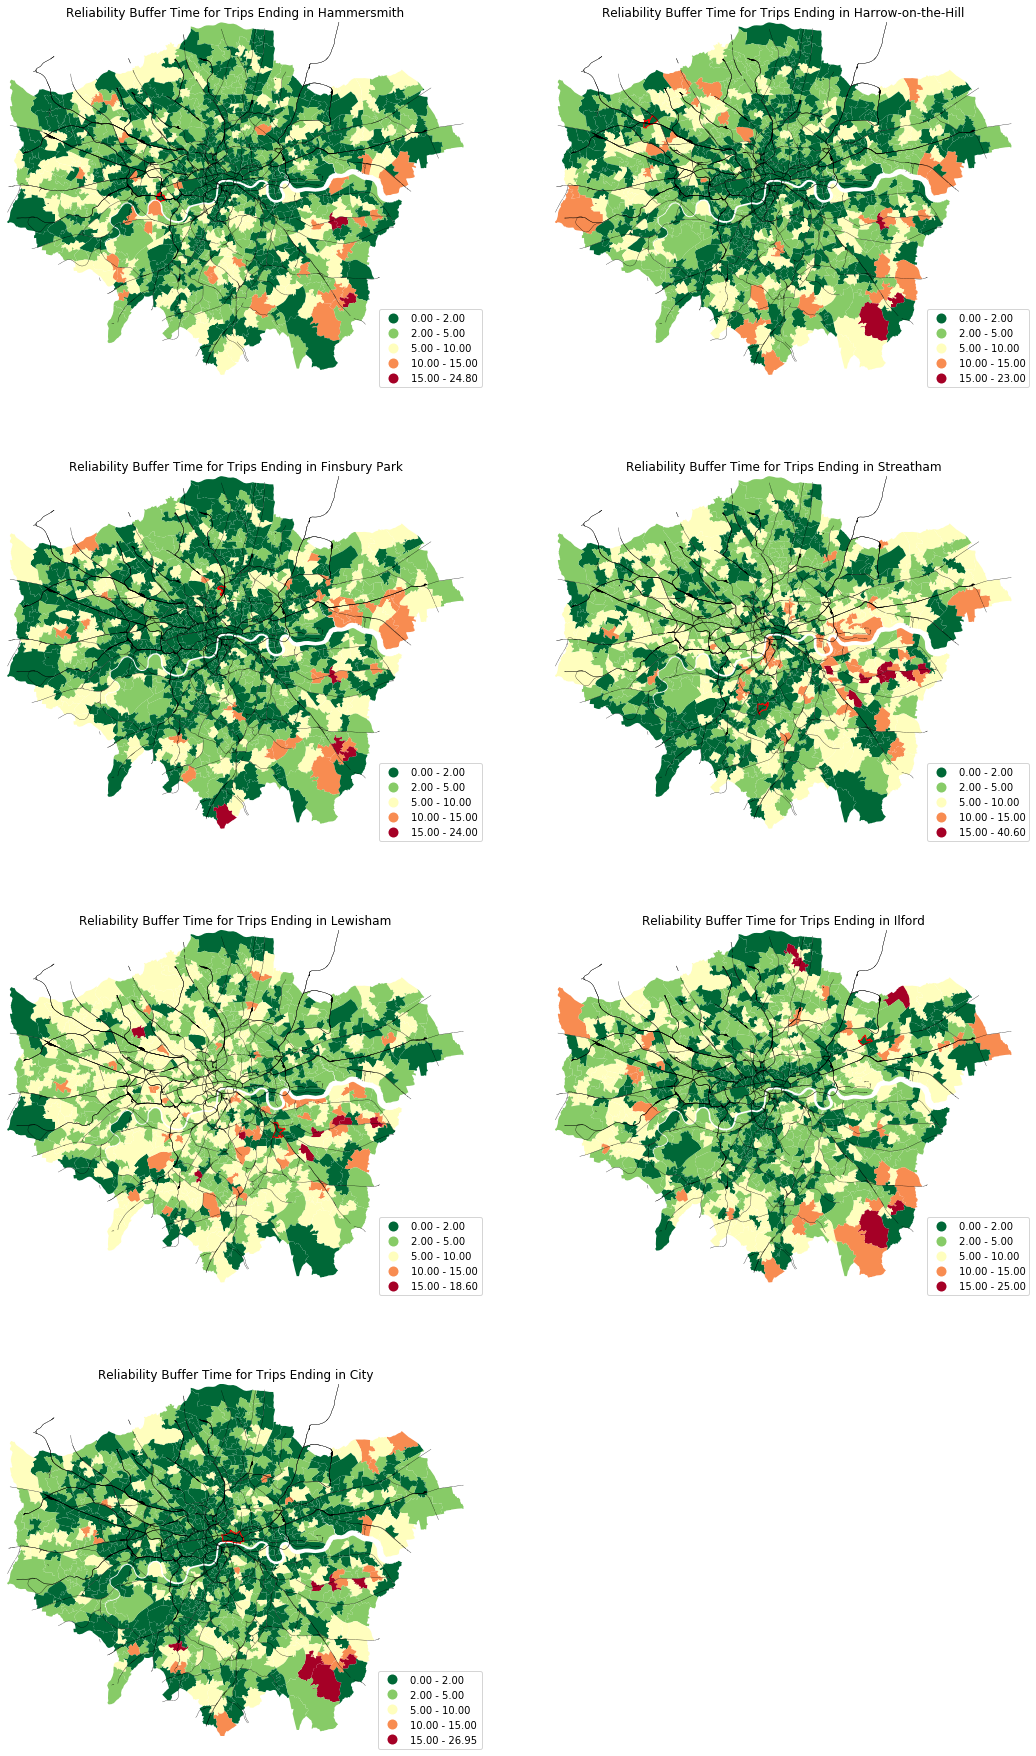

In [16]:
# plot observed variability data for trips ending in the 7 centroids
fig02 = plt.figure(figsize = (18, 8 * round(len(cluster_centroids) / 2, 0)))
for i in range(len(cluster_centroids)):
    ax02 = fig02.add_subplot(round(len(cluster_centroids) / 2, 0), 2, i + 1)
    set_zoom(ax02, msoas)
    observed_traveltimes[cluster_centroids[i]]['traveltime_variability'].plot(column = 'Range 50PC to 95PC', ax = ax02, 
                                                                              scheme = 'userdefined', 
                                                                              classification_kwds = {'bins': [2,5,10,15]},
                                                                              cmap = 'RdYlGn_r', legend = True) # 90% HPD interval width
    msoas.loc[[cluster_centroids[i]],:].plot(ax = ax02, color = 'None', edgecolor = 'red') # centroid
    londonrail.plot(color = 'black', linewidth = .3, ax = ax02)
    londontube.plot(color = 'black', linewidth = .3, ax = ax02)
    legend02 = ax02.get_legend()
    legend02.set_bbox_to_anchor((1.05, .2))
    plt.title('Reliability Buffer Time for Trips Ending in ' + centroid_names[cluster_centroids[i]])
    plt.axis('off')

### Compile RBT for Trips to City and to Local Destinations

In [17]:
# compile RBT to the local centroid
local_orig_variability = pd.DataFrame()
for i in range(len(cluster_centroids[:-1])):
    local_cluster = clustered_msoas[clustered_msoas['cluster'] == i].index
    local_orig_variability = pd.concat([local_orig_variability, observed_traveltimes[cluster_centroids[i]]['traveltime_variability'].loc[local_cluster, 'Range 50PC to 95PC']])
local_orig_variability.rename({0: 'Range 50PC to 95PC to Local Centroid'}, axis = 1, inplace = True)
local_orig_variability = local_orig_variability.loc[msoas.index,:]

# join in RBT to City
traveltimevariability = local_orig_variability.join(observed_traveltimes['E02000001']['traveltime_variability']['Range 50PC to 95PC'])
traveltimevariability.rename({'Range 50PC to 95PC': 'Range 50PC to 95PC to City'}, axis = 1, inplace = True)

In [18]:
print('RBT data for', len(traveltimevariability), 'MSOAs compiled.')
traveltimevariability.head()

RBT data for 983 MSOAs compiled.


,Range 50PC to 95PC to Local Centroid,Range 50PC to 95PC to City
MSOA,,
E02000001,1.0,0.0
E02000002,5.8,4.0
E02000003,1.6,2.0
E02000004,1.0,3.0
E02000005,6.0,4.0


### Write Out Useful Datasets

In [19]:
with open('../90 Data/compiled secondary data/traveltimevariability', 'wb') as outfile:
    pickle.dump(traveltimevariability, outfile)